In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import time as pctime

# load national data

In [2]:
# dati cumulativi

data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
xdata=pd.to_numeric(range(data.shape[0]))
ydata=data['totale_casi']
ydata_death=data['deceduti']
ydata_rec=data['dimessi_guariti']

ydata_inf=ydata-ydata_rec-ydata_death

print(data.iloc[-1,0])

data.head()

2020-04-21T17:00:00


,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN,NaN


In [3]:
# dati differenziali

ydata_incr=[]
ydata_death_incr=[]
ydata_rec_incr=[]

for i in range(len(ydata)-1):
    ydata_incr.append(ydata[i+1]-ydata[i])
    ydata_death_incr.append(ydata_death[i+1]-ydata_death[i])
    ydata_rec_incr.append(ydata_rec[i+1]-ydata_rec[i])

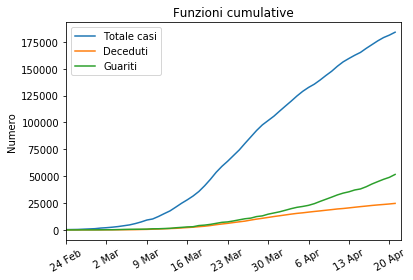

In [4]:
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Funzioni cumulative')
plt.legend()
#plt.savefig('output3/dataonly.png')
plt.show()

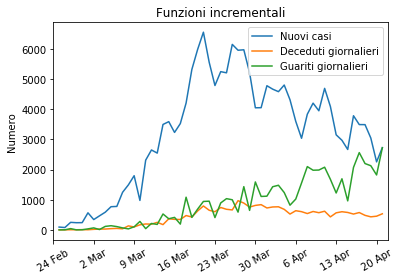

In [5]:
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Funzioni incrementali')
plt.legend()
#plt.savefig('output3/dataonly_deriv.png')
plt.show()

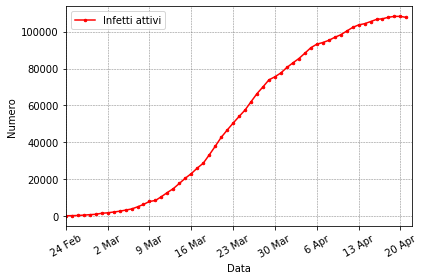

In [6]:
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',marker='.',markersize=5,label='Infetti attivi')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
#plt.ylim(0,120000)
plt.xlabel('Data')
plt.ylabel('Numero')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('output3/sirdatacomp_prediction_dataonly.png',dpi=300)
plt.show()

# definition of the models

### definition of SIR 1.0

In [7]:
# The SIR model differential equations.
def deriv_SIR(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

def SIR(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### definition of SIR 2.0 

In [8]:
# The SIR model differential equations.
def deriv_SIR_2(y, t, N, beta1,gamma,beta2,tau=10**6):
    S,I,R = y
    
    if t<=14:      # il lockdown nazionale inizia al 14° giorno 
        B=beta1
    else: 
        B=beta2*np.exp(-(t-14)/tau)

    dSdt = -(B*I/N)*S 
    dIdt = (B*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt


def SIR_2(N,beta1,gamma,beta2,tau=10**6,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIR_2, y0, t, args=(N,beta1,gamma,beta2,tau))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

# fitting the active infected

In [9]:
# 3 parameter fit for the active infected

def optimizer_adv(R0,R02,tau):
    fin_result_updated=SIR_2(6*10**7,R0*1/14,1/14,R02*1/14,tau,I0=ydata_inf[0])
    i_vec=fin_result_updated[2]
    
    #pesi=np.exp(-np.arange(len(ydata_inf))/7)
    #pesi=pesi[::-1]
    
    accuracy=np.sum((ydata_inf-i_vec[0:len(ydata_inf)])**2)   #mean squared error. This is used for the optimization
    
    errperc=np.mean(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    stdperc=np.std(np.abs((ydata_inf-i_vec[0:len(ydata_inf)])/ydata_inf))*100
    
    return accuracy,errperc,stdperc

In [10]:
# grid on 3 parameters
R0grid=np.linspace(4.5,5,10)
R02grid=np.linspace(3,3.5,10)
taugrid=np.linspace(33,35,20)

res_scan=[]
counter=0
counter2=0
cycle_tot=len(R0grid)*len(R02grid)*len(taugrid)

time1=pctime.time()

# minimization

for r in R0grid:
    for r2 in R02grid:
        for tau in taugrid:
            opt_res=optimizer_adv(r,r2,tau)
            res_scan.append([r,r2,tau,opt_res[0],opt_res[1],opt_res[2]])
            counter=counter+1
            counter2=counter2+1
            if counter2==cycle_tot/10:
                time2=pctime.time()
                remtime=round((time2-time1)/counter*(cycle_tot-counter),1)
                print('completed ',round(counter/cycle_tot*100,1),'%. Remaining time ',remtime,'sec')
                counter2=0
        
res_scan=np.array(res_scan)

completed  10.0 %. Remaining time  22.4 sec
completed  20.0 %. Remaining time  19.8 sec
completed  30.0 %. Remaining time  17.7 sec
completed  40.0 %. Remaining time  13.5 sec
completed  50.0 %. Remaining time  10.4 sec
completed  60.0 %. Remaining time  7.8 sec
completed  70.0 %. Remaining time  5.6 sec
completed  80.0 %. Remaining time  3.6 sec
completed  90.0 %. Remaining time  1.8 sec
completed  100.0 %. Remaining time  0.0 sec


In [11]:
df_res_scan=pd.DataFrame(res_scan)
df_res_scan.columns=['R0','R0lock','tau','MSE','mean err%','std err%']

df_res_scan.sort_values(by='MSE')

,R0,R0lock,tau,MSE,mean err%,std err%
1247,4.833333,3.111111,33.736842,2.633707e+08,7.815272,8.689367
1248,4.833333,3.111111,33.842105,2.710922e+08,7.848985,8.664961
1246,4.833333,3.111111,33.631579,2.728310e+08,7.809681,8.705249
1063,4.777778,3.166667,33.315789,2.765764e+08,7.129169,7.505207
1062,4.777778,3.166667,33.210526,2.788898e+08,7.119881,7.526215
...,...,...,...,...,...,...
1995,5.000000,3.500000,34.578947,3.484687e+11,72.293928,43.654354
1996,5.000000,3.500000,34.684211,3.569284e+11,72.910429,44.309455
1997,5.000000,3.500000,34.789474,3.655194e+11,73.528083,44.968240
1998,5.000000,3.500000,34.894737,3.742425e+11,74.146884,45.630663


In [12]:
par_ideal=np.array(df_res_scan.sort_values(by='MSE').iloc[0,0:])

par_ideal[0:3]

array([ 4.83333333,  3.11111111, 33.73684211])

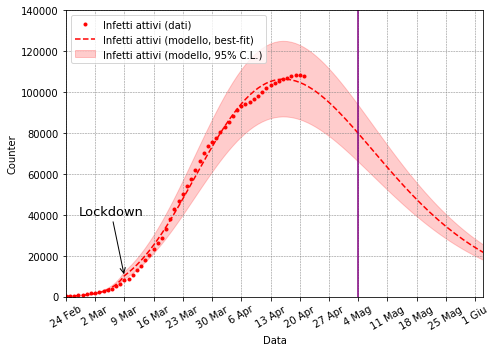

In [13]:
fin_result_updated=SIR_2(6*10**7,par_ideal[0]*1/14,1/14,par_ideal[1]*1/14,par_ideal[2],I0=ydata_inf[0])

t=fin_result_updated[0]
i_vec=fin_result_updated[2]

plt.figure(figsize=(7,5))
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*2),i_vec*(1-par_ideal[5]/100*2), label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70,[-1000,140000],color='purple')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,100)
plt.ylim(0,140000)
plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('output/fit_con_incertezza.png',dpi=300)
plt.show()  

In [14]:
i_vec[70]*(1+par_ideal[5]/100*2),i_vec[70]*(1-par_ideal[5]/100*2)

(93791.5373129776, 66018.56607515085)

In [15]:
#export

t_date=pd.to_datetime(t,unit='D',origin=pd.Timestamp('2020-02-24'))

export_v2 = pd.DataFrame({'date':t_date,'t':t, 'infetti best fit': i_vec,'infetti upper lim':i_vec*(1+par_ideal[5]/100*2),'infetti lower lim':i_vec*(1-par_ideal[5]/100*2)})
export_v2.to_csv('output3/nazionale_v2.csv',index=False)

# computation of national R0

### using data of last 5 days

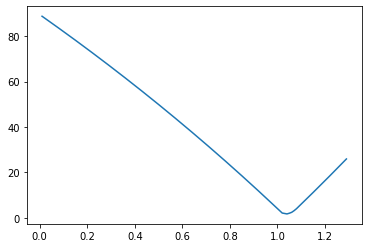

In [16]:
today=len(xdata)

def minimizer(R0,t1=today-5,t2=today):
    
    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))
    
    #model
    fin_result=SIR(60*10**6,0.1*R0,0.1,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]
    
    #average error
    error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100
    
    return error

minimizer_vec=np.vectorize(minimizer)


#definition of the ideal r0

xgrid=np.arange(0.01,1.3,0.01)
ygrid=minimizer_vec(xgrid)
r0_ideal=round(xgrid[np.argmin(ygrid)],2)
r0_ideal

plt.plot(xgrid,ygrid)
plt.show()

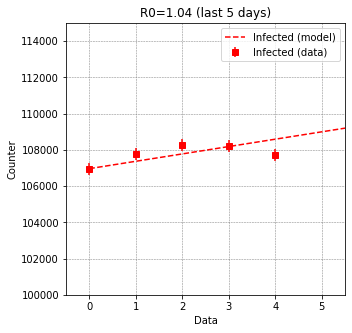

In [17]:
ydata_inf_2=np.array(ydata_inf[today-5:today])
xdata_2=np.arange(0,len(ydata_inf_2))

fin_result=SIR(60*10**6,0.1*r0_ideal,0.1,I0=ydata_inf_2[0])

t_R0=fin_result[0]
#s_vec=fin_result[1]
i_vec_R0=fin_result[2]
#r_vec=fin_result[3]

plt.figure(figsize=(5,5))
plt.errorbar(xdata_2,ydata_inf_2,np.sqrt(ydata_inf_2),color='red',linestyle='None',marker='s',label='Infected (data)')
plt.plot(t_R0, i_vec_R0, 'r--', label='Infected (model)')
#plt.yscale('log')
#plt.xticks(np.arange(14,70,7),['21 Feb','28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr'],rotation=30)
plt.xlim(-0.5,5.5)
plt.ylim(10**5,1.15*10**5)
#plt.ylim(0,300)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('R0='+str(r0_ideal)+' (last 5 days)')
#plt.savefig('output3/r0-5days.png',dpi=300)
plt.show()

### scan of R0 over time

In [23]:
time_window=5

def minimizer_gen(t1,t2,xgrid=np.arange(0.1,5,0.01)):

    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]
scangrid=np.linspace(0,5,50)

for i in range(today-(time_window-1)):
    min_val=minimizer_gen(i,i+time_window,xgrid=scangrid)
    r0_time.append(min_val)
    scangrid=np.linspace(0,min_val+1,100)  #the grid change over the time (this speed up the process)
    print('Day n',i,' R0=',min_val)
    
r0_time=np.array(r0_time)

Day n 0  R0= 4.29
Day n 1  R0= 4.06
Day n 2  R0= 4.5
Day n 3  R0= 3.89
Day n 4  R0= 3.56
Day n 5  R0= 3.55
Day n 6  R0= 2.8
Day n 7  R0= 2.96
Day n 8  R0= 2.88
Day n 9  R0= 3.1
Day n 10  R0= 3.19
Day n 11  R0= 3.34
Day n 12  R0= 2.85
Day n 13  R0= 2.72
Day n 14  R0= 2.56
Day n 15  R0= 2.88
Day n 16  R0= 2.7
Day n 17  R0= 2.54
Day n 18  R0= 2.43
Day n 19  R0= 2.29
Day n 20  R0= 2.16
Day n 21  R0= 2.23
Day n 22  R0= 2.22
Day n 23  R0= 2.31
Day n 24  R0= 2.14
Day n 25  R0= 1.93
Day n 26  R0= 1.78
Day n 27  R0= 1.71
Day n 28  R0= 1.7
Day n 29  R0= 1.66
Day n 30  R0= 1.67
Day n 31  R0= 1.59
Day n 32  R0= 1.41
Day n 33  R0= 1.36
Day n 34  R0= 1.29
Day n 35  R0= 1.32
Day n 36  R0= 1.34
Day n 37  R0= 1.3
Day n 38  R0= 1.3
Day n 39  R0= 1.28
Day n 40  R0= 1.22
Day n 41  R0= 1.14
Day n 42  R0= 1.12
Day n 43  R0= 1.16
Day n 44  R0= 1.18
Day n 45  R0= 1.17
Day n 46  R0= 1.18
Day n 47  R0= 1.15
Day n 48  R0= 1.11
Day n 49  R0= 1.09
Day n 50  R0= 1.1
Day n 51  R0= 1.08
Day n 52  R0= 1.05
Day n 53  R

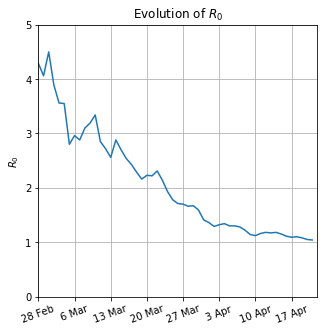

In [19]:
plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid()
plt.title('Evolution of $R_0$')
#plt.savefig('output3/r0-evo.png',dpi=300)
plt.show()

In [20]:
# export R0 over time

df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time)),unit='D',origin='2020-02-28'))
df_r0['R0']=r0_time
df_r0.columns=['Data','R0']

df_r0.to_csv('output3/r0.csv',index=False)

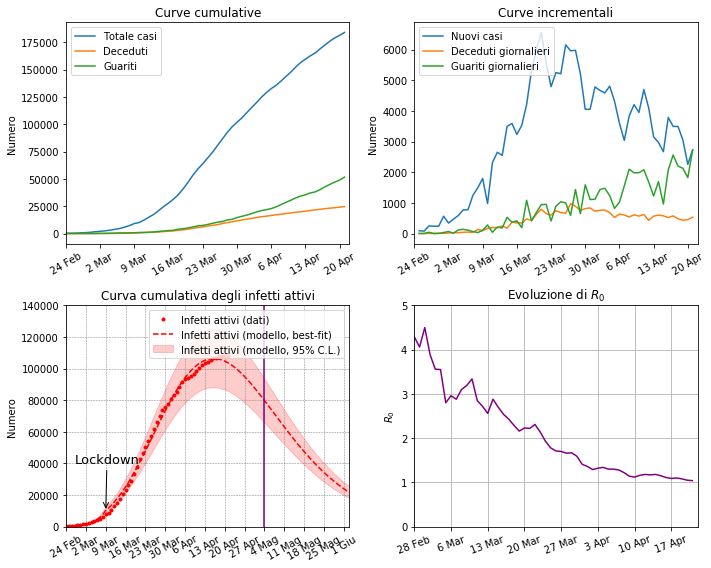

In [21]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(np.arange(len(ydata)),ydata,label='Totale casi')
plt.plot(np.arange(len(ydata)),ydata_death,label='Deceduti')
plt.plot(np.arange(len(ydata)),ydata_rec,label='Guariti')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,len(ydata))
plt.ylabel('Numero')
plt.title('Curve cumulative')
plt.legend()
plt.subplot(2,2,2)
plt.plot(np.arange(len(ydata_incr)),ydata_incr,label='Nuovi casi')
plt.plot(np.arange(len(ydata_incr)),ydata_death_incr,label='Deceduti giornalieri')
plt.plot(np.arange(len(ydata_incr)),ydata_rec_incr,label='Guariti giornalieri')
plt.xticks(np.arange(-1,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(-1,len(ydata_incr))
plt.ylabel('Numero')
plt.title('Curve incrementali')
plt.legend()
plt.subplot(2,2,3)
plt.plot(np.arange(len(ydata_inf)),ydata_inf,color='red',linestyle='None',marker='.',label='Infetti attivi (dati)')
plt.plot(t, i_vec, label='Infetti attivi (modello, best-fit)',color='red',linestyle='--')
plt.fill_between(t, i_vec*(1+par_ideal[5]/100*2),i_vec*(1-par_ideal[5]/100*2), label='Infetti attivi (modello, 95% C.L.)',color='red',alpha=.2)
plt.plot(np.zeros(2)+70,[-1000,140000],color='purple')
plt.xticks(np.arange(0,100,7),['24 Feb','2 Mar','9 Mar','16 Mar','23 Mar','30 Mar','6 Apr','13 Apr','20 Apr','27 Apr','4 Mag','11 Mag','18 Mag','25 Mag','1 Giu'],rotation=30)
plt.xlim(0,100)
plt.ylim(0,140000)
plt.annotate("Lockdown", xy=(14,10000), xytext=(3,40000), arrowprops=dict(arrowstyle="->"),fontsize=13)
plt.title('Curva cumulativa degli infetti attivi')
plt.ylabel('Numero')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.subplot(2,2,4)
plt.plot(r0_time,color='purple')
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.xlim(0,today-4)
#plt.xlim(19,today-9)
plt.ylabel('$R_0$')
plt.ylim(0,5)
plt.grid()
plt.title('Evoluzione di $R_0$')
plt.tight_layout()
plt.savefig('output3/4plots.png',dpi=300)